In [6]:
from pathlib import Path
import cv2
import collections
import numpy as np
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torch.nn import functional as f
from PIL import Image
from matplotlib import pyplot as plt
import time
from moco_model import MoCo
import json
from torchvision import transforms
import timm

In [8]:
figuresPath = Path('E:/datasets/NDI_images/Integreted/Observed')
file_names = list(figuresPath.glob('*.jpg'))
max_value_dict = collections.defaultdict(int)
min_value_dict = collections.defaultdict(int)
for file_name in file_names:
    img = cv2.imread(str(file_name), cv2.IMREAD_UNCHANGED)
    max_value_dict[np.max(img)] += 1
    min_value_dict[np.min(img)] += 1
print('max_value_dict', max_value_dict)
print('min_value_dict', min_value_dict)

max_value_dict defaultdict(<class 'int'>, {252: 9, 255: 102, 253: 10, 249: 6, 243: 2, 251: 11, 254: 7, 238: 1, 247: 5, 246: 7, 245: 4, 250: 7, 241: 3, 244: 2, 240: 1, 248: 4, 239: 2, 242: 1})
min_value_dict defaultdict(<class 'int'>, {0: 184})


In [9]:
normalized_pic_path = Path.joinpath(figuresPath, 'normalized_pics')
for file_name in file_names:
    file_stem = file_name.name
    img = cv2.imread(str(file_name), cv2.IMREAD_UNCHANGED)
    if np.max(img) != 255:
        img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        cv2.imwrite(str(Path.joinpath(normalized_pic_path, file_stem)), img_norm)
    else:
        cv2.imwrite(str(Path.joinpath(normalized_pic_path, file_stem)), img)

In [10]:
file_names = list(normalized_pic_path.glob('*.jpg'))
max_value_dict = collections.defaultdict(int)
min_value_dict = collections.defaultdict(int)
for file_name in file_names:
    img = cv2.imread(str(file_name), cv2.IMREAD_UNCHANGED)
    max_value_dict[np.max(img)] += 1
    min_value_dict[np.min(img)] += 1
print('max_value_dict', max_value_dict)
print('min_value_dict', min_value_dict)

max_value_dict defaultdict(<class 'int'>, {253: 14, 255: 139, 254: 27, 251: 2, 252: 2})
min_value_dict defaultdict(<class 'int'>, {0: 184})


In [11]:
average_rec = [83, 80, 117, 120]
xbegin, ybegin, xend, yend = average_rec
mask_pics_path = Path.joinpath(figuresPath, 'masked_pics')
file_names = list(normalized_pic_path.glob('*.jpg'))
for file_name in file_names:
    file_stem = file_name.name
    img = cv2.imread(str(file_name), cv2.IMREAD_UNCHANGED)
    img[xbegin: xend, ybegin: yend] = 0
    cv2.imwrite(str(Path.joinpath(mask_pics_path, file_stem)), img)

In [12]:
file_names = list(mask_pics_path.glob('*.jpg'))
centrosymmetric_pics_path = Path.joinpath(figuresPath, 'centrosysmmetric_pics')
for file_name in file_names:
    file_stem = file_name.name
    img = cv2.imread(str(file_name), cv2.IMREAD_UNCHANGED)
    height, width = img.shape
    for i in range(height):
        for j in range(width):
            img[j, i] = max(img[j, i], img[width - j - 1, height - i - 1])
    cv2.imwrite(str(Path.joinpath(centrosymmetric_pics_path, file_stem)), img)

KeyboardInterrupt: 

In [13]:
binaryzation_pics_path = Path.joinpath(figuresPath, 'binaryzation_pics')
file_names = list(centrosymmetric_pics_path.glob('*.jpg'))
for file_name in file_names:
    file_stem = file_name.name
    img = cv2.imread(str(file_name), cv2.IMREAD_UNCHANGED)
    result, threshold = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
    cv2.imwrite(str(Path.joinpath(binaryzation_pics_path, file_stem)), threshold)

In [15]:
circle_mask_pics_path = Path.joinpath(figuresPath, 'circle_masked_pics')
file_names = list(normalized_pic_path.glob('*.jpg'))
for file_name in file_names:
    file_stem = file_name.name
    img = cv2.imread(str(file_name), cv2.IMREAD_UNCHANGED)
    height, width = img.shape
    for i in range(height):
        for j in range(width):
            if (i - 101) ** 2 + (j - 100) ** 2 <= 484:
                img[j, i] = 0
    cv2.imwrite(str(Path.joinpath(circle_mask_pics_path, file_stem)), img)

In [16]:
file_names = list(circle_mask_pics_path.glob('*.jpg'))
circle_centrosymmetric_pics_path = Path.joinpath(figuresPath, 'circle_centrosysmmetric_pics')
for file_name in file_names:
    file_stem = file_name.name
    img = cv2.imread(str(file_name), cv2.IMREAD_UNCHANGED)
    height, width = img.shape
    for i in range(height):
        for j in range(width):
            img[j, i] = max(img[j, i], img[width - j - 1, height - i - 1])
    cv2.imwrite(str(Path.joinpath(circle_centrosymmetric_pics_path, file_stem)), img)

In [17]:
circle_binaryzation_pics_path = Path.joinpath(figuresPath, 'circle_binaryzation_pics')
file_names = list(circle_centrosymmetric_pics_path.glob('*.jpg'))
for file_name in file_names:
    file_stem = file_name.name
    img = cv2.imread(str(file_name), cv2.IMREAD_UNCHANGED)
    result, threshold = cv2.threshold(img, 110, 255, cv2.THRESH_BINARY)
    cv2.imwrite(str(Path.joinpath(circle_binaryzation_pics_path, file_stem)), threshold)

In [7]:
def image_pair_matching(net, original_image, matching_image):
    net.eval()
    q = net.encoder_q(original_image)
    q = f.normalize(q, dim=1)
    k = net.encoder_k(matching_image)
    k = f.normalize(k, dim=1)
    logits = torch.einsum('nc,ck->nk', [q, k.T])
    return logits

def cal_accuracy(preds, label):
    return float(torch.sum(torch.argmax(preds, dim=1).type_as(label) == label))

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class HistoryRecorder:
    def __init__(self, names):
        self.data = {name: [] for name in names}
        self.names = names

    def add(self, *args):
        for name, value in zip(self.names, args):
            self.data[name].append(value)

    def reset(self):
        self.data = {name: [] for name in self.names}

    def __getitem__(self, name):
        return self.data[name]

def train_moco_return_metrics(net, criterion, optimizer, epochs, device):
    train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
    to_tensor_func = torchvision.transforms.ToTensor()
    target_tensor = []
    for i in range(1, 185):
        target_tensor.append(to_tensor_func(Image.open(str(Path.joinpath(Path(TARGET_IMAGE), f'{i}.jpg')))).unsqueeze(0))
    target_tensor = torch.cat(target_tensor, dim=0)
    target_tensor = target_tensor.cuda(device)
    for epoch in range(epochs):
        net.cuda(device)
        total_loss = 0
        training_correct = 0
        training_size = 0
        for origin, target, label in train_iter:
            net.train()
            origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
            output, labels = net(origin, target)
            loss = criterion(output, labels)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            net.eval()
            with torch.no_grad():
                training_correct += cal_accuracy(image_pair_matching(net, origin, target_tensor), label)
                training_size += origin.shape[0]
        net.eval()
        with torch.no_grad():
            val_loss = 0
            val_correct = 0
            for origin, target, label in val_iter:
                origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
                output, labels = net(origin, target, evaluate=True)
                val_loss += f.cross_entropy(output, labels).item()
                val_correct += cal_accuracy(image_pair_matching(net, origin, target_tensor), label)
        val_acc = val_correct / origin.shape[0]
        train_metrics.add(total_loss / len(train_iter), training_correct / training_size, val_loss / len(val_iter), val_acc)
        print(f'Epoch {epoch + 1}, Loss {total_loss / len(train_iter)}, Train_acc {training_correct / training_size}, Val_loss {val_loss / len(val_iter)}, Val_acc {val_acc}')
    return train_metrics

In [3]:
class NDIDatasetContrastiveLearning(Dataset):
    def __init__(self):
        super(NDIDatasetContrastiveLearning, self).__init__()
        original_images = list(Path(ORIGINAL_IMAGE).glob('*.jpg'))
        origins, targets, labels = [], [], []
        to_tensor_func = torchvision.transforms.ToTensor()
        for original_image in original_images:
            origins.append(to_tensor_func(Image.open(str(original_image))))
            targets.append(to_tensor_func(Image.open(str(Path.joinpath(Path(TARGET_IMAGE), original_image.name)))))
            labels.append(int(original_image.name.split('.')[0]) - 1)
        random_index = np.random.permutation(len(origins))
        self.origins, self.targets, self.labels = [], [], []
        for index in random_index:
            self.origins.append(origins[index])
            self.targets.append(targets[index])
            self.labels.append(labels[index])

    def __getitem__(self, idx):
        return self.origins[idx], self.targets[idx], self.labels[idx]

    def __len__(self):
        return len(self.origins)

## Circle Binarized Images

In [4]:
ORIGINAL_IMAGE = 'E:/datasets/NDI_images/Integreted/Observed/circle_binaryzation_pics'
TARGET_IMAGE = 'E:/datasets/NDI_images/Integreted/Calculated/grayscale'

Epoch 1, Loss 2.6130024722668166, Train_acc 0.00625, Val_loss 1.722551703453064, Val_acc 0.0
Epoch 2, Loss 2.744132709503174, Train_acc 0.0125, Val_loss 1.8281596899032593, Val_acc 0.0
Epoch 3, Loss 2.569949173927307, Train_acc 0.00625, Val_loss 1.6362794637680054, Val_acc 0.0
Epoch 4, Loss 2.3036333560943603, Train_acc 0.00625, Val_loss 1.4279370307922363, Val_acc 0.0
Epoch 5, Loss 2.2740071296691893, Train_acc 0.0, Val_loss 1.7636674642562866, Val_acc 0.0
Epoch 6, Loss 2.20940363407135, Train_acc 0.01875, Val_loss 2.739755630493164, Val_acc 0.0
Epoch 7, Loss 2.05627099275589, Train_acc 0.01875, Val_loss 2.685070037841797, Val_acc 0.041666666666666664
Epoch 8, Loss 2.1664289593696595, Train_acc 0.0625, Val_loss 2.739086866378784, Val_acc 0.0
Epoch 9, Loss 1.9578374862670898, Train_acc 0.13125, Val_loss 2.528032064437866, Val_acc 0.0
Epoch 10, Loss 1.8453804969787597, Train_acc 0.16875, Val_loss 2.4785430431365967, Val_acc 0.041666666666666664
Epoch 11, Loss 1.6301950454711913, Train_a

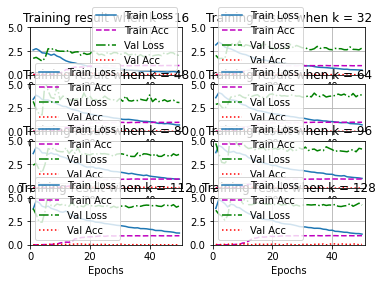

In [6]:
metrics = {}
k_values = [16, 32, 48, 64, 80, 96, 112, 128]
fmts = ('-', 'm--', 'g-.', 'r:')
X = [np.arange(1, 51, 1) for _ in range(4)]
fig, axes = plt.subplots(4, 2)
axes = axes.flatten()
dataset = NDIDatasetContrastiveLearning()
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [160, 24])
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
for k, ax in zip(k_values, axes):
    model = MoCo(torchvision.models.resnet18, dim=128, K=k)
    device = torch.device('cuda:0')
    criterion = nn.CrossEntropyLoss().cuda(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
    start_time = time.time()
    sub_metrics = train_moco_return_metrics(model, criterion, optimizer, 50, device)
    end_time = time.time()
    metrics[k] = sub_metrics.data
    metrics[k]['Training time'] = round(end_time - start_time, 2)
    for x, y, fmt in zip(X, sub_metrics.names, fmts):
        ax.plot(x, sub_metrics.data[y], fmt)
    ax.set_xlabel('Epochs')
    ax.set_xlim([0, 51])
    ax.set_ylim([0, 5])
    ax.legend(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
    ax.grid()
    ax.set_title(f'Training result when k = {k}')
plt.show()

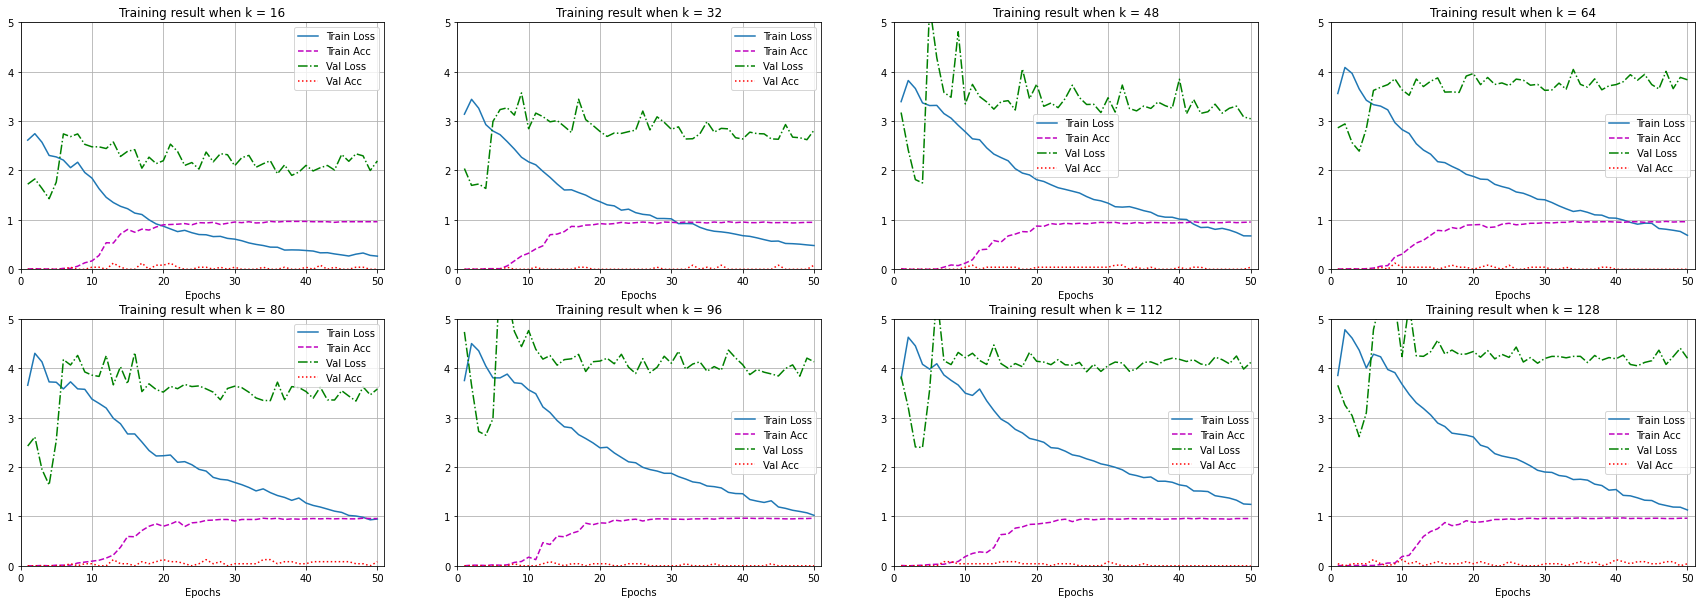

In [7]:
with open('circle_binarized_different_k_result.json', 'w', encoding='utf-8') as f:
    json.dump(metrics, f)
with open('circle_binarized_different_k_result.json', 'r', encoding='utf-8') as f:
    a = json.load(f)
a.keys()
fig, axes = plt.subplots(2, 4, figsize=(30, 10))
axes = axes.flatten()
X = [np.arange(1, 51, 1) for _ in range(4)]
fmts = ('-', 'm--', 'g-.', 'r:')
names = ['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc']
for k, ax in zip(a.keys(), axes):
    for x, y, fmt in zip(X, names, fmts):
        ax.plot(x, a[k][y], fmt)
    ax.set_xlabel('Epochs')
    ax.set_xlim([0, 51])
    ax.set_ylim([0, 5])
    ax.legend(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
    ax.grid()
    ax.set_title(f'Training result when k = {k}')
plt.show()

## Circle Centrosysmmetric

Epoch 1, Loss 2.5994878007448277, Train_acc 0.00625, Val_loss 1.9978467226028442, Val_acc 0.0
Epoch 2, Loss 2.7728848457336426, Train_acc 0.00625, Val_loss 2.0302531719207764, Val_acc 0.0
Epoch 3, Loss 2.5890679121017457, Train_acc 0.0, Val_loss 1.9199342727661133, Val_acc 0.0
Epoch 4, Loss 2.2774730563163756, Train_acc 0.00625, Val_loss 0.9190558791160583, Val_acc 0.0
Epoch 5, Loss 2.159899055957794, Train_acc 0.0125, Val_loss 1.984404444694519, Val_acc 0.0
Epoch 6, Loss 2.4113099813461303, Train_acc 0.0125, Val_loss 3.5397942066192627, Val_acc 0.0
Epoch 7, Loss 2.209683966636658, Train_acc 0.025, Val_loss 2.57088303565979, Val_acc 0.0
Epoch 8, Loss 2.1417797446250915, Train_acc 0.0375, Val_loss 2.884127378463745, Val_acc 0.0
Epoch 9, Loss 2.0546872854232787, Train_acc 0.075, Val_loss 4.152839183807373, Val_acc 0.041666666666666664
Epoch 10, Loss 2.0514551520347597, Train_acc 0.05, Val_loss 3.715070962905884, Val_acc 0.041666666666666664
Epoch 11, Loss 2.018257808685303, Train_acc 0.0

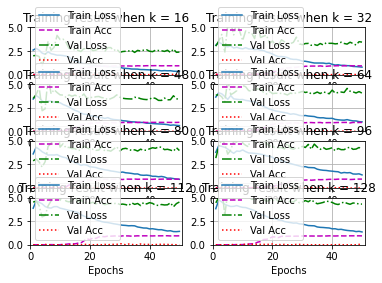

In [4]:
ORIGINAL_IMAGE = 'E:/datasets/NDI_images/Integreted/Observed/circle_centrosysmmetric_pics'
TARGET_IMAGE = 'E:/datasets/NDI_images/Integreted/Calculated/grayscale'
metrics = {}
k_values = [16, 32, 48, 64, 80, 96, 112, 128]
fmts = ('-', 'm--', 'g-.', 'r:')
X = [np.arange(1, 51, 1) for _ in range(4)]
fig, axes = plt.subplots(4, 2)
axes = axes.flatten()
dataset = NDIDatasetContrastiveLearning()
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [160, 24])
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
for k, ax in zip(k_values, axes):
    model = MoCo(torchvision.models.resnet18, dim=128, K=k)
    device = torch.device('cuda:0')
    criterion = nn.CrossEntropyLoss().cuda(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
    start_time = time.time()
    sub_metrics = train_moco_return_metrics(model, criterion, optimizer, 50, device)
    end_time = time.time()
    metrics[k] = sub_metrics.data
    metrics[k]['Training time'] = round(end_time - start_time, 2)
    for x, y, fmt in zip(X, sub_metrics.names, fmts):
        ax.plot(x, sub_metrics.data[y], fmt)
    ax.set_xlabel('Epochs')
    ax.set_xlim([0, 51])
    ax.set_ylim([0, 5])
    ax.legend(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
    ax.grid()
    ax.set_title(f'Training result when k = {k}')
plt.show()

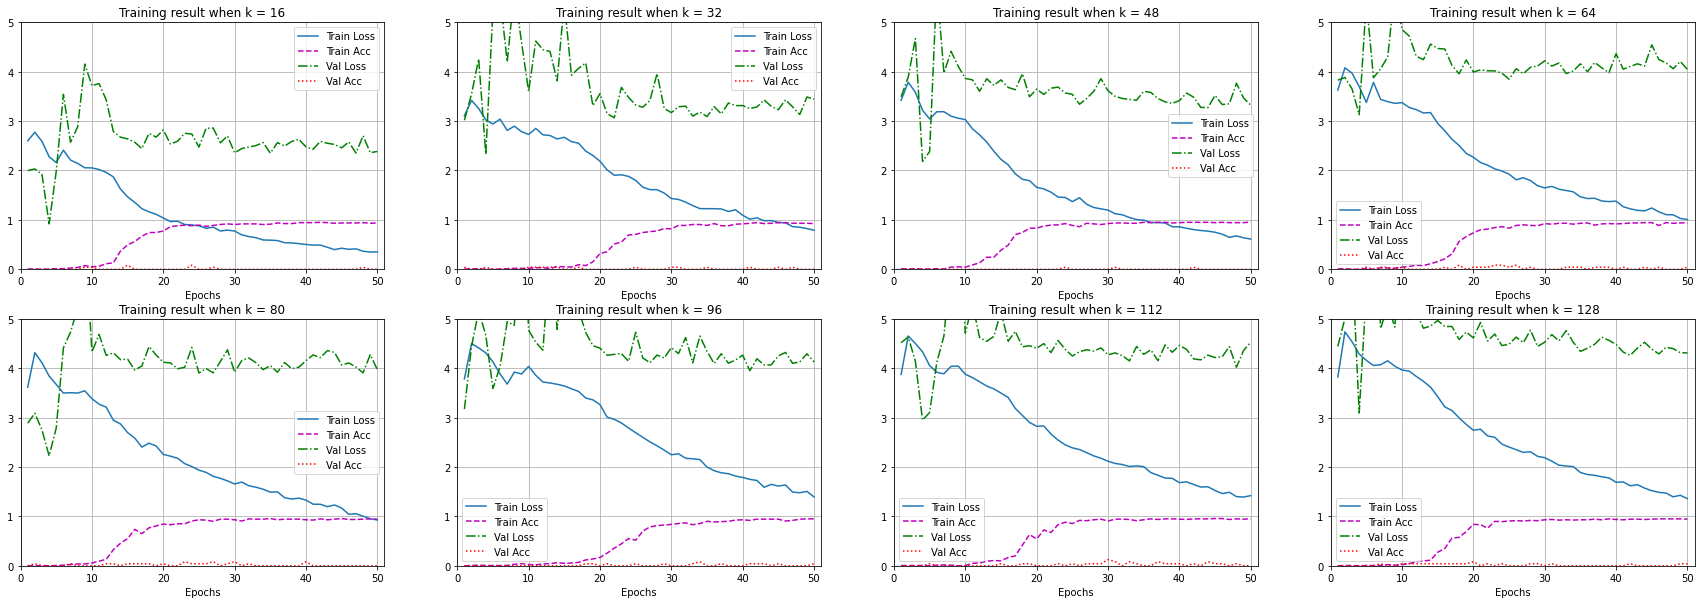

In [5]:
with open('circle_centrosysmmetric_different_k_result.json', 'w', encoding='utf-8') as f:
        json.dump(metrics, f)
with open('circle_centrosysmmetric_different_k_result.json', 'r', encoding='utf-8') as f:
    a = json.load(f)
a.keys()
fig, axes = plt.subplots(2, 4, figsize=(30, 10))
axes = axes.flatten()
X = [np.arange(1, 51, 1) for _ in range(4)]
fmts = ('-', 'm--', 'g-.', 'r:')
names = ['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc']
for k, ax in zip(a.keys(), axes):
    for x, y, fmt in zip(X, names, fmts):
        ax.plot(x, a[k][y], fmt)
    ax.set_xlabel('Epochs')
    ax.set_xlim([0, 51])
    ax.set_ylim([0, 5])
    ax.legend(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
    ax.grid()
    ax.set_title(f'Training result when k = {k}')
plt.show()

## 用AlexNet

Epoch 1, Loss 3.3968166305192424, Train_acc 0.00625, Val_loss 3.7485952377319336, Val_acc 0.0
Epoch 2, Loss 3.8959468603134155, Train_acc 0.00625, Val_loss 3.7432992458343506, Val_acc 0.0
Epoch 3, Loss 3.8723376750946046, Train_acc 0.00625, Val_loss 3.7336585521698, Val_acc 0.0
Epoch 4, Loss 3.8639338493347166, Train_acc 0.00625, Val_loss 3.7453014850616455, Val_acc 0.0
Epoch 5, Loss 3.857848858833313, Train_acc 0.00625, Val_loss 3.752420425415039, Val_acc 0.0
Epoch 6, Loss 3.8480910778045656, Train_acc 0.00625, Val_loss 3.7505204677581787, Val_acc 0.0
Epoch 7, Loss 3.847637891769409, Train_acc 0.00625, Val_loss 3.7506980895996094, Val_acc 0.0
Epoch 8, Loss 3.8558918714523314, Train_acc 0.00625, Val_loss 3.710604667663574, Val_acc 0.0
Epoch 9, Loss 3.833348774909973, Train_acc 0.00625, Val_loss 3.734149217605591, Val_acc 0.0
Epoch 10, Loss 3.8381325960159303, Train_acc 0.00625, Val_loss 3.709975004196167, Val_acc 0.041666666666666664
Epoch 11, Loss 3.842471742630005, Train_acc 0.0, Val

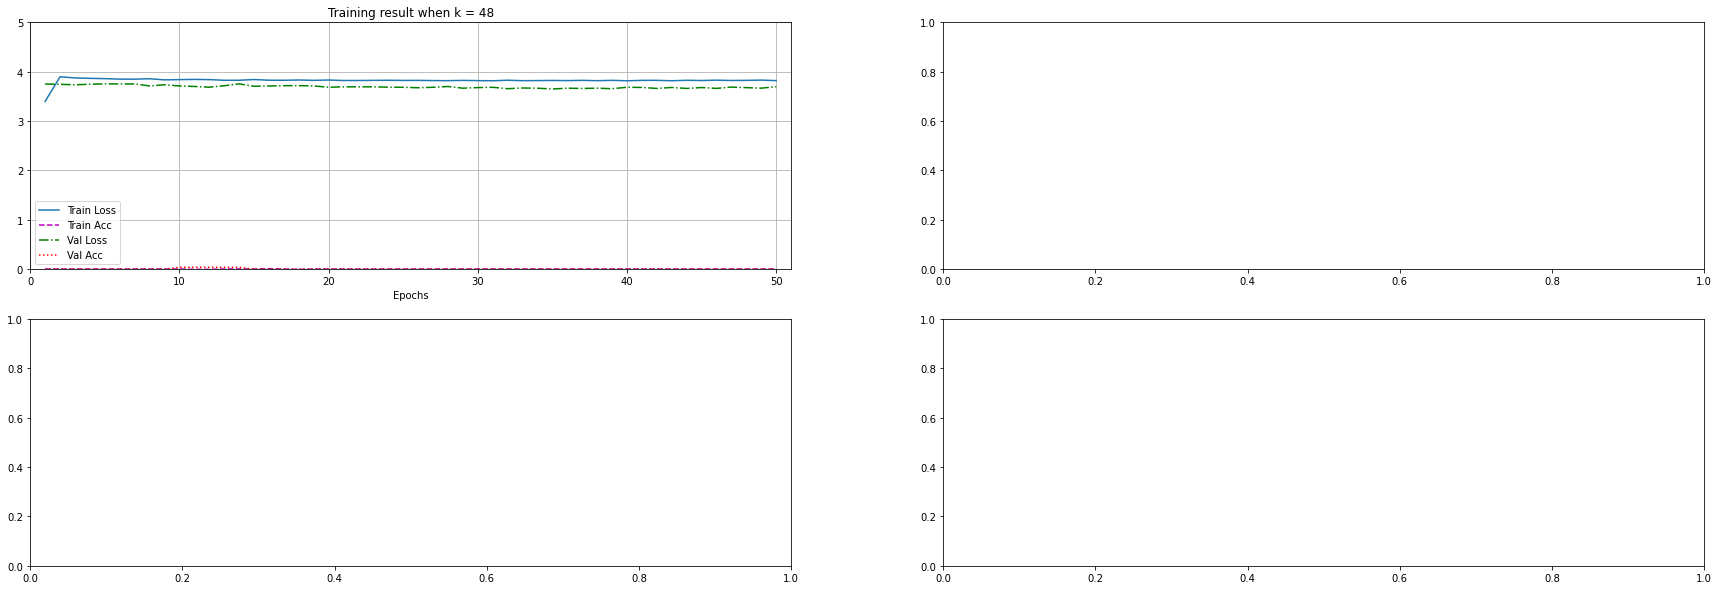

In [7]:
ORIGINAL_IMAGE = 'E:/datasets/NDI_images/Integreted/Observed/circle_binaryzation_pics'
TARGET_IMAGE = 'E:/datasets/NDI_images/Integreted/Calculated/grayscale'
metrics = {}
# k_values = [48, 64, 80, 96]
k_values = [48]
fmts = ('-', 'm--', 'g-.', 'r:')
X = [np.arange(1, 51, 1) for _ in range(4)]
fig, axes = plt.subplots(2, 2, figsize=(30, 10))
axes = axes.flatten()
dataset = NDIDatasetContrastiveLearning()
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [160, 24])
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
for k, ax in zip(k_values, axes):
    model = MoCo(torchvision.models.alexnet, dim=512, K=k, model_type='alexnet')
    device = torch.device('cuda:0')
    criterion = nn.CrossEntropyLoss().cuda(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
    start_time = time.time()
    sub_metrics = train_moco_return_metrics(model, criterion, optimizer, 50, device)
    end_time = time.time()
    metrics[k] = sub_metrics.data
    metrics[k]['Training time'] = round(end_time - start_time, 2)
names = ['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc']
for k, ax in zip(metrics.keys(), axes):
    for x, y, fmt in zip(X, names, fmts):
        ax.plot(x, metrics[k][y], fmt)
    ax.set_xlabel('Epochs')
    ax.set_xlim([0, 51])
    ax.set_ylim([0, 5])
    ax.legend(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
    ax.grid()
    ax.set_title(f'Training result when k = {k}')
plt.show()

## 用ResNet34

Epoch 1, Loss 3.4066755696265316, Train_acc 0.0, Val_loss 2.3646020889282227, Val_acc 0.0
Epoch 2, Loss 3.821335482597351, Train_acc 0.00625, Val_loss 2.308335781097412, Val_acc 0.0
Epoch 3, Loss 3.7358049869537355, Train_acc 0.00625, Val_loss 1.765118956565857, Val_acc 0.0
Epoch 4, Loss 3.5328215599060058, Train_acc 0.00625, Val_loss 1.8660484552383423, Val_acc 0.0
Epoch 5, Loss 3.232888960838318, Train_acc 0.00625, Val_loss 2.045233964920044, Val_acc 0.0
Epoch 6, Loss 3.105995440483093, Train_acc 0.0125, Val_loss 2.6156985759735107, Val_acc 0.0
Epoch 7, Loss 3.170912337303162, Train_acc 0.0125, Val_loss 4.012481212615967, Val_acc 0.041666666666666664
Epoch 8, Loss 3.2463330268859862, Train_acc 0.0, Val_loss 7.541279315948486, Val_acc 0.041666666666666664
Epoch 9, Loss 3.2161471843719482, Train_acc 0.00625, Val_loss 4.5451226234436035, Val_acc 0.0
Epoch 10, Loss 3.103958559036255, Train_acc 0.025, Val_loss 4.323429584503174, Val_acc 0.041666666666666664
Epoch 11, Loss 3.03505589962005

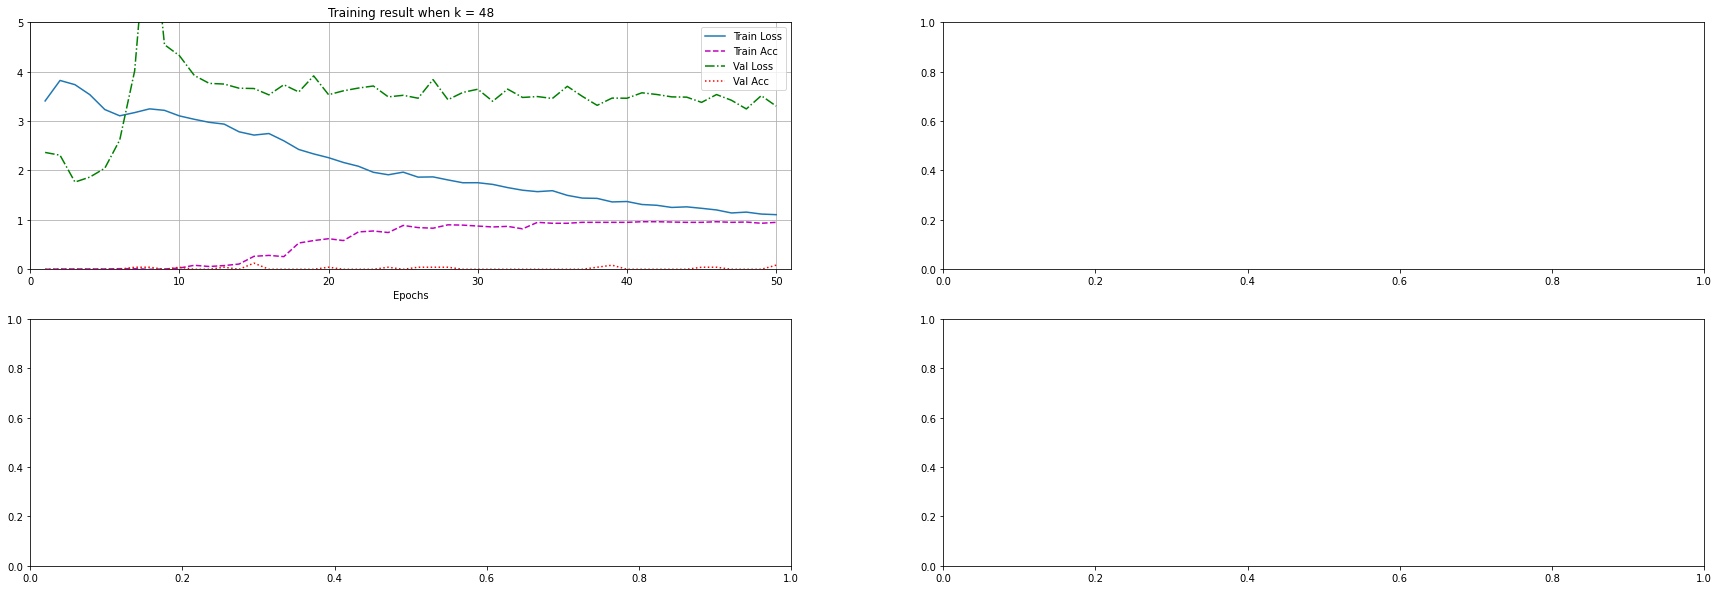

In [8]:
# 用ResNet34

ORIGINAL_IMAGE = 'E:/datasets/NDI_images/Integreted/Observed/circle_binaryzation_pics'
TARGET_IMAGE = 'E:/datasets/NDI_images/Integreted/Calculated/grayscale'
metrics = {}
# k_values = [48, 64, 80, 96]
k_values = [48]
fmts = ('-', 'm--', 'g-.', 'r:')
X = [np.arange(1, 51, 1) for _ in range(4)]
fig, axes = plt.subplots(2, 2, figsize=(30, 10))
axes = axes.flatten()
dataset = NDIDatasetContrastiveLearning()
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [160, 24])
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
for k, ax in zip(k_values, axes):
    model = MoCo(torchvision.models.resnet34, dim=512, K=k, model_type='resnet')
    device = torch.device('cuda:0')
    criterion = nn.CrossEntropyLoss().cuda(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
    start_time = time.time()
    sub_metrics = train_moco_return_metrics(model, criterion, optimizer, 50, device)
    end_time = time.time()
    metrics[k] = sub_metrics.data
    metrics[k]['Training time'] = round(end_time - start_time, 2)
names = ['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc']
for k, ax in zip(metrics.keys(), axes):
    for x, y, fmt in zip(X, names, fmts):
        ax.plot(x, metrics[k][y], fmt)
    ax.set_xlabel('Epochs')
    ax.set_xlim([0, 51])
    ax.set_ylim([0, 5])
    ax.legend(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
    ax.grid()
    ax.set_title(f'Training result when k = {k}')
plt.show()

In [8]:
model = torchvision.models.resnet18()

In [9]:
model.fc.in_features

Linear(in_features=512, out_features=1000, bias=True)

In [10]:
for name in model.named_modules():
    print(name)

('', MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, tr

In [5]:
# 变成3通道
ORIGINAL_IMAGE = 'E:/datasets/NDI_images/Integreted/Observed/circle_binaryzation_pics'
TARGET_IMAGE = 'E:/datasets/NDI_images/Integreted/Calculated/'
class ThreeChannelNDIDatasetContrastiveLearning(Dataset):
    def __init__(self):
        super(ThreeChannelNDIDatasetContrastiveLearning, self).__init__()
        original_images = list(Path(ORIGINAL_IMAGE).glob('*.jpg'))
        origins, targets, labels = [], [], []
        to_tensor_func = torchvision.transforms.ToTensor()
        for original_image in original_images:
            origins.append(to_tensor_func(Image.open(str(original_image)).convert('RGB')))
            targets.append(to_tensor_func(Image.open(str(Path.joinpath(Path(TARGET_IMAGE), original_image.name)))))
            labels.append(int(original_image.name.split('.')[0]) - 1)
        random_index = np.random.permutation(len(origins))
        self.origins, self.targets, self.labels = [], [], []
        for index in random_index:
            self.origins.append(origins[index])
            self.targets.append(targets[index])
            self.labels.append(labels[index])

    def __getitem__(self, idx):
        return self.origins[idx], self.targets[idx], self.labels[idx]

    def __len__(self):
        return len(self.origins)

In [5]:
dataset = ThreeChannelNDIDatasetContrastiveLearning()
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [160, 24])
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
for x, y, z in train_iter:
    print(x.shape)
    print(y.shape)
    print(z.shape)
    break

torch.Size([16, 3, 200, 200])
torch.Size([16, 3, 200, 200])
torch.Size([16])


Epoch 1, Loss 3.3793960388051345, Train_acc 0.00625, Val_loss 4.531557559967041, Val_acc 0.0
Epoch 2, Loss 3.3548662662506104, Train_acc 0.0, Val_loss 3.702113389968872, Val_acc 0.08333333333333333
Epoch 3, Loss 2.5307302236557008, Train_acc 0.00625, Val_loss 3.521754503250122, Val_acc 0.0
Epoch 4, Loss 1.9583391070365905, Train_acc 0.0, Val_loss 3.37150502204895, Val_acc 0.041666666666666664
Epoch 5, Loss 1.600641393661499, Train_acc 0.01875, Val_loss 3.369218111038208, Val_acc 0.0
Epoch 6, Loss 1.2528670310974122, Train_acc 0.05625, Val_loss 3.850598096847534, Val_acc 0.041666666666666664
Epoch 7, Loss 1.0067144632339478, Train_acc 0.1375, Val_loss 3.9685943126678467, Val_acc 0.041666666666666664
Epoch 8, Loss 0.8583456695079803, Train_acc 0.4625, Val_loss 3.9777286052703857, Val_acc 0.041666666666666664
Epoch 9, Loss 0.723000556230545, Train_acc 0.84375, Val_loss 3.346240758895874, Val_acc 0.041666666666666664
Epoch 10, Loss 0.5828107595443726, Train_acc 0.95, Val_loss 3.58301544189

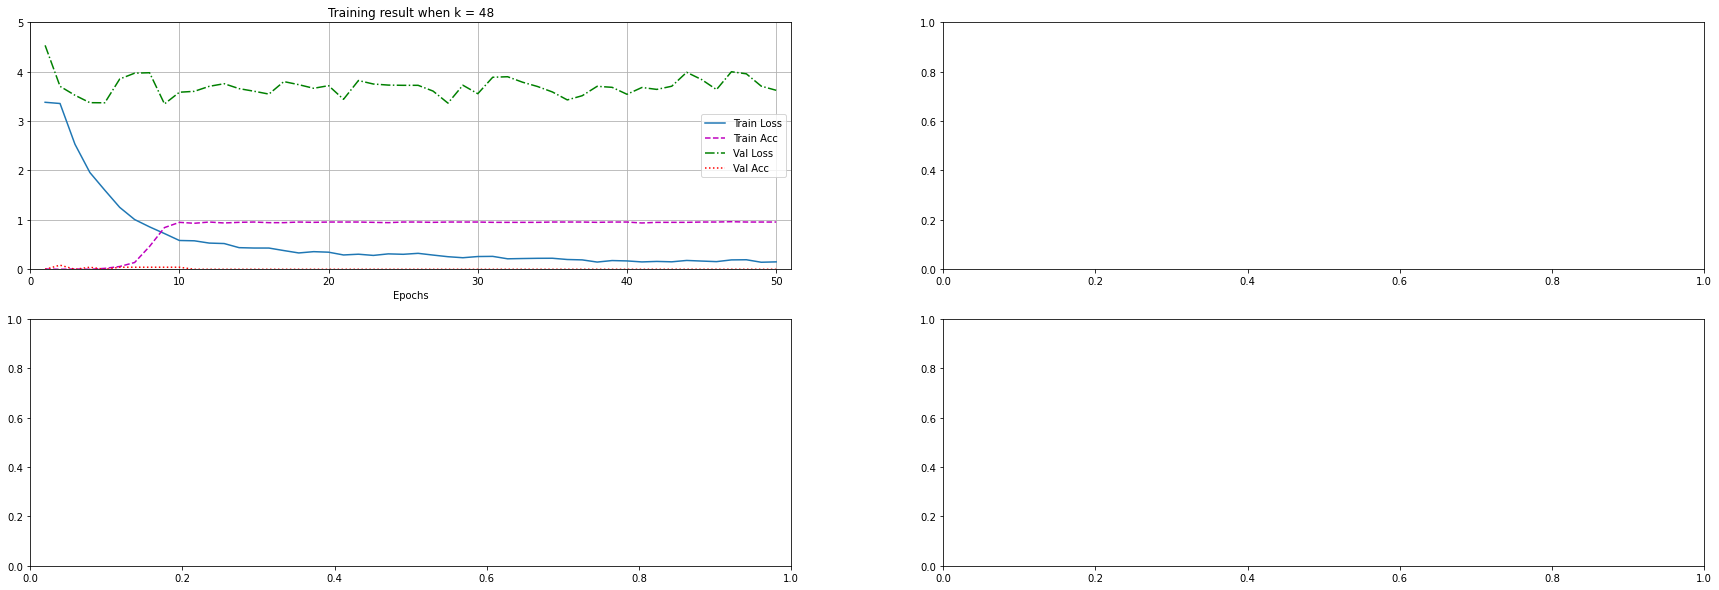

In [6]:
metrics = {}
# k_values = [48, 64, 80, 96]
k_values = [48]
fmts = ('-', 'm--', 'g-.', 'r:')
X = [np.arange(1, 51, 1) for _ in range(4)]
fig, axes = plt.subplots(2, 2, figsize=(30, 10))
axes = axes.flatten()
dataset = ThreeChannelNDIDatasetContrastiveLearning()
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [160, 24])
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
for k, ax in zip(k_values, axes):
    model = MoCo(torchvision.models.resnet18, dim=512, K=k, model_type='resnet', pretrained=True, three_channel=True)
    device = torch.device('cuda:0')
    criterion = nn.CrossEntropyLoss().cuda(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
    start_time = time.time()
    sub_metrics = train_moco_return_metrics(model, criterion, optimizer, 50, device)
    end_time = time.time()
    metrics[k] = sub_metrics.data
    metrics[k]['Training time'] = round(end_time - start_time, 2)
names = ['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc']
for k, ax in zip(metrics.keys(), axes):
    for x, y, fmt in zip(X, names, fmts):
        ax.plot(x, metrics[k][y], fmt)
    ax.set_xlabel('Epochs')
    ax.set_xlim([0, 51])
    ax.set_ylim([0, 5])
    ax.legend(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
    ax.grid()
    ax.set_title(f'Training result when k = {k}')
plt.show()

In [9]:
class HistoryRecorder:
    def __init__(self, names, structure=None):
        if structure:
            if len(names) != len(structure):
                raise IndexError('The length of names and the length of structure should be equal')
            self.data = {name: s() for name, s in zip(names, structure)}
        else:
            self.data = {name: [] for name in names}
        self.names = names
        self.structure = structure

    def add(self, *args):
        if len(self.names) < len(args):
            raise IndexError('Too much values to record')
        else:
            for i in range(min(len(self.names), len(args))):
                if isinstance(self.data[self.names[i]], list):
                    self.data[self.names[i]].append(args[i])
                elif isinstance(self.data[self.names[i]], dict):
                    for k, v in args[i].items():
                        if k not in self.data[self.names[i]]:
                            self.data[self.names[i]][k] = [v]
                        else:
                            self.data[self.names[i]][k].append(v)

    def reset(self):
        if self.structure:
            self.data = {name: s() for name, s in zip(names, self.structure)}
        else:
            self.data = {name: [] for name in names}

    def __getitem__(self, name):
        return self.data[name]

def cal_accuracy_top_k(preds, label, top_k=(1, )):
    result = []
    max_k = max(top_k)
    sample_num = preds.shape[0]
    pred_scores, pred_labels = preds.topk(max_k, dim=1)
    pred_labels = pred_labels.t()
    correct = pred_labels.eq(label.view(1, -1).expand_as(pred_labels))
    for k in top_k:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        result.append(correct_k.item())
    return result

def image_pair_matching(net, original_image, matching_image):
    net.eval()
    q = net.encoder_q(original_image)
    q = f.normalize(q, dim=1)
    k = net.encoder_k(matching_image)
    k = f.normalize(k, dim=1)
    logits = torch.einsum('nc,ck->nk', [q, k.T])
    return logits

def train_moco_return_metrics_top_k(net, criterion, optimizer, epochs, device):
    train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], [list, dict, list, dict])
    to_tensor_func = torchvision.transforms.ToTensor()
    target_tensor = []
    k_candidates = (1, 5, 10)
    for i in range(1, 185):
        target_tensor.append(to_tensor_func(Image.open(str(Path.joinpath(Path(TARGET_IMAGE), f'{i}.jpg')))).unsqueeze(0))
    target_tensor = torch.cat(target_tensor, dim=0)
    target_tensor = target_tensor.cuda(device)
    for epoch in range(epochs):
        net.cuda(device)
        total_loss = 0
        training_correct = collections.defaultdict(int)
        training_size = 0
        for origin, target, label in train_iter:
            net.train()
            origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
            output, labels = net(origin, target)
            loss = criterion(output, labels)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            net.eval()
            with torch.no_grad():
                for k, correct in zip(k_candidates, cal_accuracy_top_k(image_pair_matching(net, origin, target_tensor), label, top_k=k_candidates)):
                    training_correct[k] += correct
                training_size += origin.shape[0]
        net.eval()
        with torch.no_grad():
            val_loss = 0
            val_correct = collections.defaultdict(int)
            for origin, target, label in val_iter:
                origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
                output, labels = net(origin, target, evaluate=True)
                val_loss += f.cross_entropy(output, labels).item()
                for k, correct in zip(k_candidates, cal_accuracy_top_k(image_pair_matching(net, origin, target_tensor), label, top_k=k_candidates)):
                    val_correct[k] += correct
        val_acc = {k: correct / origin.shape[0] for k, correct in val_correct.items()}
        train_acc = {k: correct / training_size for k, correct in training_correct.items()}
        train_metrics.add(total_loss / len(train_iter), train_acc, val_loss / len(val_iter), val_acc)
        print(f'Epoch {epoch + 1}, Train_Loss {total_loss / len(train_iter)}, Val_loss {val_loss / len(val_iter)}')
        for k, acc in train_acc.items():
            print(f'Train_acc_top_{k} {round(acc, 2)}', end='\t')
        print()
        for k, acc in val_acc.items():
            print(f'Val_acc_top_{k} {round(acc, 2)}', end='\t')
        print()
    return train_metrics

def draw_graph(metrics):
    fmts = ('b-', 'b--', 'b-.', 'r-', 'r--', 'r-.')
    X = [np.arange(1, 26, 1) for _ in range(6)]
    fig, axes = plt.subplots(1, 1, figsize=(30, 10))
    names = ['Train Acc Top 1', 'Train Acc Top 5', 'Train Acc Top 10', 'Val Acc Top 1', 'Val Acc Top 5', 'Val Acc Top 10']
    plot_data = {k: list(metrics[k]['Train Acc'].values()) + list(metrics[k]['Val Acc'].values()) for k in metrics.keys()}
    for k in metrics.keys():
        for x, y, fmt in zip(X, list(plot_data.values())[0], fmts):
            axes.plot(x, y, fmt)
        axes.set_xlabel('Epochs')
        axes.set_xlim([0, 26])
        axes.set_ylim([0, 1])
        axes.legend(names)
        axes.grid()
        axes.set_title(f'Training result when k = {k}')
    plt.show()

In [42]:
ORIGINAL_IMAGE = 'E:/datasets/NDI_images/Integreted/Observed/circle_binaryzation_pics'
TARGET_IMAGE = 'E:/datasets/NDI_images/Integreted/Calculated/'
k_values = [48]
# dataset = ThreeChannelNDIDatasetContrastiveLearning()
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [160, 24])
# train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
# val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
metrics = {}
for k in k_values:
    model = MoCo(torchvision.models.resnet18, dim=512, K=k, model_type='resnet', pretrained=True, three_channel=True)
    device = torch.device('cuda:0')
    criterion = nn.CrossEntropyLoss().cuda(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
    start_time = time.time()
    sub_metrics = train_moco_return_metrics_top_k(model, criterion, optimizer, 25, device)
    end_time = time.time()
    metrics[k] = sub_metrics.data
    metrics[k]['Training time'] = round(end_time - start_time, 2)

Epoch 1, Train_Loss 3.3795862224069424, Val_loss 4.008389472961426
Train_acc_top_1 0.0	Train_acc_top_5 0.02	Train_acc_top_10 0.05	
Val_acc_top_1 0.04	Val_acc_top_5 0.04	Val_acc_top_10 0.04	
Epoch 2, Train_Loss 3.443090486526489, Val_loss 4.171178817749023
Train_acc_top_1 0.02	Train_acc_top_5 0.04	Train_acc_top_10 0.09	
Val_acc_top_1 0.0	Val_acc_top_5 0.08	Val_acc_top_10 0.21	
Epoch 3, Train_Loss 2.6313831567764283, Val_loss 3.4643993377685547
Train_acc_top_1 0.01	Train_acc_top_5 0.02	Train_acc_top_10 0.04	
Val_acc_top_1 0.0	Val_acc_top_5 0.04	Val_acc_top_10 0.04	
Epoch 4, Train_Loss 2.10440411567688, Val_loss 3.6016035079956055
Train_acc_top_1 0.0	Train_acc_top_5 0.05	Train_acc_top_10 0.07	
Val_acc_top_1 0.0	Val_acc_top_5 0.04	Val_acc_top_10 0.12	
Epoch 5, Train_Loss 1.6404791235923768, Val_loss 3.7993786334991455
Train_acc_top_1 0.01	Train_acc_top_5 0.09	Train_acc_top_10 0.14	
Val_acc_top_1 0.04	Val_acc_top_5 0.04	Val_acc_top_10 0.12	
Epoch 6, Train_Loss 1.491011869907379, Val_loss 3.

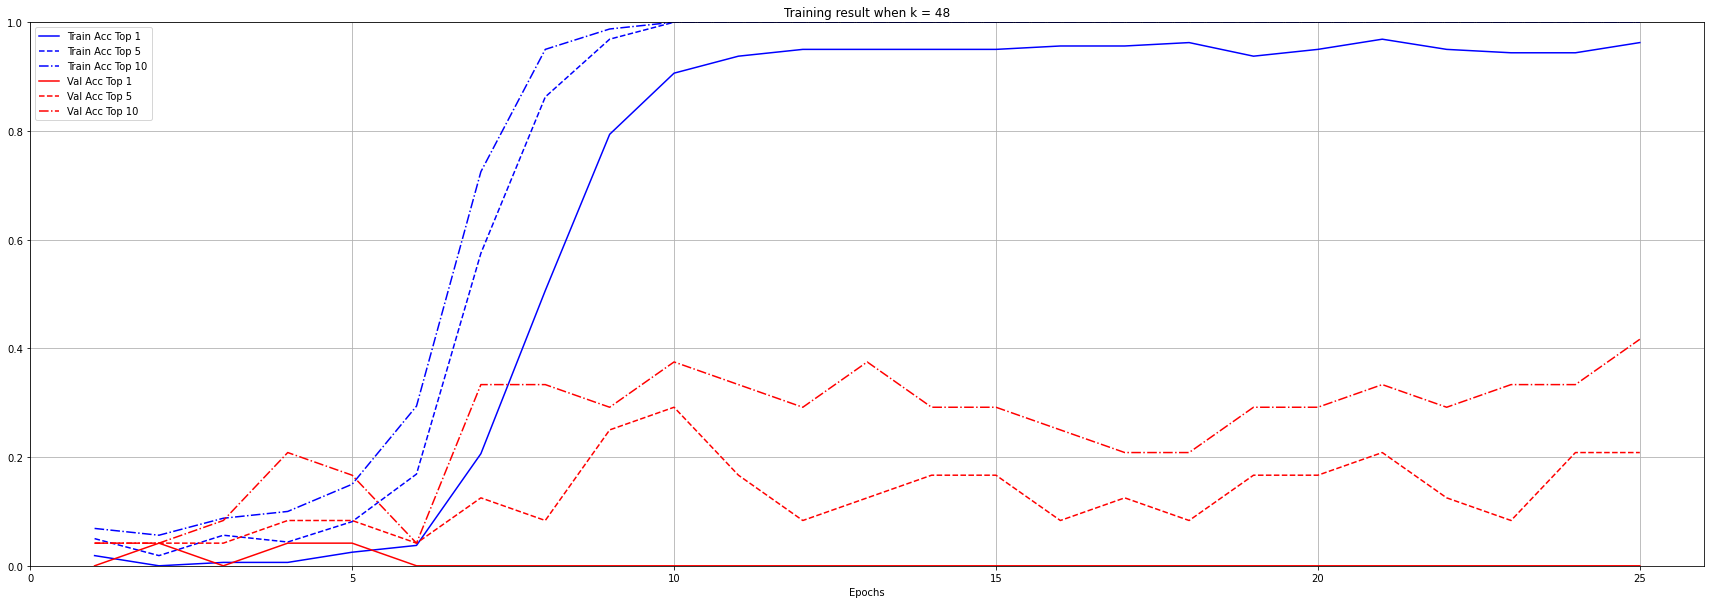

In [75]:
draw_graph(metrics)

In [63]:
plot_data = {k: list(metrics[k]['Train Acc'].values()) + list(metrics[k]['Val Acc'].values()) for k in metrics.keys()}

In [69]:
len(plot_data.values())

1

In [10]:
def split_train_validation_randomly(original_path, target_path):
    original_images = list(sorted(list(map(str, list(Path(original_path).glob('*.jpg'))))))
    target_images = list(sorted(list(map(str, list(Path(target_path).glob('*.jpg'))))))
    images = list(zip(original_images, target_images))
    train_images, val_images = torch.utils.data.random_split(images, [160, 24])
    return train_images, val_images


In [11]:
class ThreeChannelNDIDatasetContrastiveLearningWithAug(Dataset):
    def __init__(self, images, evaluate=False):
        super(ThreeChannelNDIDatasetContrastiveLearningWithAug, self).__init__()
        if not evaluate:
            self.images = images[0]
        else:
            self.images = images[1]
        # 水平翻转 + 随机旋转 训练慢（100）但是效果好
        # 水平翻转 可以提升一点点
        self.transforms = transforms.Compose([
            transforms.GaussianBlur(kernel_size=3, sigma=0.7),
            # transforms.CenterCrop(150),
            # transforms.Resize(200),
            transforms.RandomHorizontalFlip(0.5),
            # transforms.RandomRotation(30)
            ])
        self.evaluate = evaluate

    def __getitem__(self, idx):
        origin_path, target_path = self.images[idx]
        origin = Image.open(origin_path).convert('RGB')
        target = Image.open(target_path)
        if not self.evaluate:
            origin, target = self.transforms(torch.cat((transforms.ToTensor()(origin).unsqueeze(0), transforms.ToTensor()(target).unsqueeze(0)), dim=0))
        else:
            origin, target = transforms.ToTensor()(origin), transforms.ToTensor()(target)
        label = int(origin_path.split('\\')[-1].split('.')[0]) - 1
        return origin, target, label

    def __len__(self):
        return len(self.images)

In [20]:
a = torch.rand((3, 200, 200))
b = a.clone()
transforms_func = transforms.Compose([
            transforms.CenterCrop(100),
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.5),
            transforms.RandomRotation(90),
            ])
conc = torch.cat((a.unsqueeze(0), b.unsqueeze(0)), 0)
c, d = transforms_func(conc)
torch.all(c == d)

tensor(True)

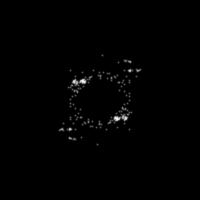

In [85]:
ORIGINAL_IMAGE = 'E:/datasets/NDI_images/Integreted/Observed/circle_binaryzation_pics'
TARGET_IMAGE = 'E:/datasets/NDI_images/Integreted/Calculated/'
a = Image.open(ORIGINAL_IMAGE + '/59.jpg').convert('RGB')
b = Image.open(TARGET_IMAGE + '/59.jpg')
transforms_func = transforms.Compose([
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=0.7)
            ])
transforms_func(a)

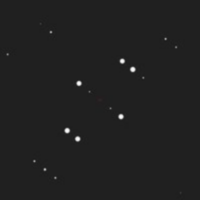

In [84]:
transforms_func(b)

In [87]:
ORIGINAL_IMAGE = 'E:/datasets/NDI_images/Integreted/Observed/circle_binaryzation_pics'
TARGET_IMAGE = 'E:/datasets/NDI_images/Integreted/Calculated/'
k_values = [48]
images = split_train_validation_randomly(ORIGINAL_IMAGE, TARGET_IMAGE)
train_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, False)
val_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, True)
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
metrics = {}
for k in k_values:
    model = MoCo(torchvision.models.resnet18, dim=512, K=k, model_type='resnet', pretrained=True, three_channel=True)
    device = torch.device('cuda:0')
    criterion = nn.CrossEntropyLoss().cuda(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
    start_time = time.time()
    sub_metrics = train_moco_return_metrics_top_k(model, criterion, optimizer, 50, device)
    end_time = time.time()
    metrics[k] = sub_metrics.data
    metrics[k]['Training time'] = round(end_time - start_time, 2)

Epoch 1, Train_Loss 3.3606702969176694, Val_loss 3.9593563079833984
Train_acc_top_1 0.01	Train_acc_top_5 0.04	Train_acc_top_10 0.07	
Val_acc_top_1 0.0	Val_acc_top_5 0.08	Val_acc_top_10 0.08	
Epoch 2, Train_Loss 3.4779587745666505, Val_loss 3.2643778324127197
Train_acc_top_1 0.01	Train_acc_top_5 0.04	Train_acc_top_10 0.06	
Val_acc_top_1 0.0	Val_acc_top_5 0.04	Val_acc_top_10 0.04	
Epoch 3, Train_Loss 2.9129096031188966, Val_loss 3.6475000381469727
Train_acc_top_1 0.01	Train_acc_top_5 0.03	Train_acc_top_10 0.04	
Val_acc_top_1 0.04	Val_acc_top_5 0.08	Val_acc_top_10 0.17	
Epoch 4, Train_Loss 2.4396464586257935, Val_loss 3.7551956176757812
Train_acc_top_1 0.01	Train_acc_top_5 0.03	Train_acc_top_10 0.06	
Val_acc_top_1 0.04	Val_acc_top_5 0.04	Val_acc_top_10 0.08	
Epoch 5, Train_Loss 2.20934419631958, Val_loss 3.744945764541626
Train_acc_top_1 0.02	Train_acc_top_5 0.04	Train_acc_top_10 0.06	
Val_acc_top_1 0.04	Val_acc_top_5 0.04	Val_acc_top_10 0.08	
Epoch 6, Train_Loss 1.873666512966156, Val_lo

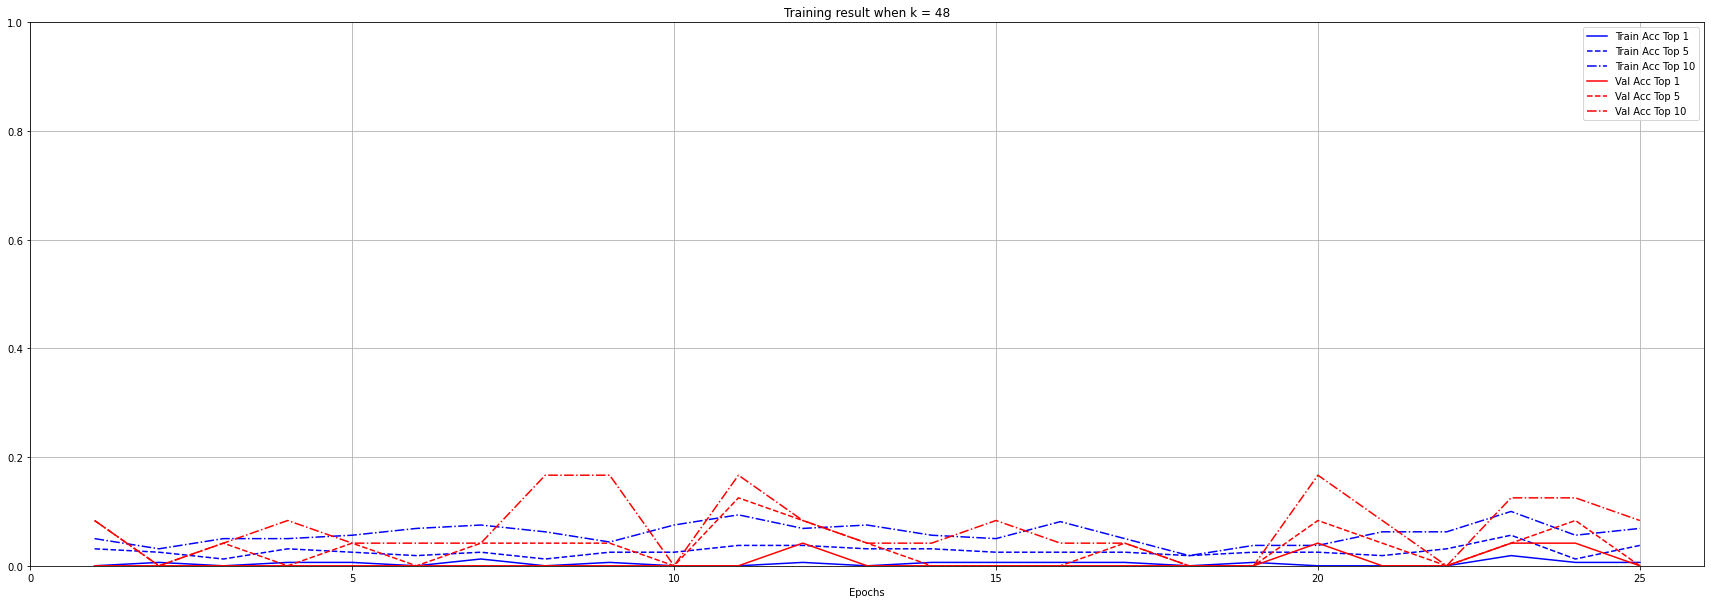

In [34]:
draw_graph(metrics)

In [4]:
convnexts = timm.list_models('*convnext*')
convnexts

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [5]:
model = timm.create_model('convnext_base', pretrained=True)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to C:\Users\43571/.cache\torch\hub\checkpoints\convnext_base_1k_224_ema.pth


In [7]:
import torchsummary

torchsummary.summary(model, input_size=(3, 200, 200), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 50, 50]           6,272
       LayerNorm2d-2          [-1, 128, 50, 50]             256
          Identity-3          [-1, 128, 50, 50]               0
            Conv2d-4          [-1, 128, 50, 50]           6,400
         LayerNorm-5          [-1, 50, 50, 128]             256
            Linear-6          [-1, 50, 50, 512]          66,048
              GELU-7          [-1, 50, 50, 512]               0
           Dropout-8          [-1, 50, 50, 512]               0
            Linear-9          [-1, 50, 50, 128]          65,664
          Dropout-10          [-1, 50, 50, 128]               0
              Mlp-11          [-1, 50, 50, 128]               0
         Identity-12          [-1, 128, 50, 50]               0
    ConvNeXtBlock-13          [-1, 128, 50, 50]               0
           Conv2d-14          [-1, 128,

In [17]:
test_input = torch.rand((1, 3, 200, 200))
model(test_input).shape[-1]

512

## Using ConvNext

In [13]:
ORIGINAL_IMAGE = 'E:/datasets/NDI_images/Integreted/Observed/circle_binaryzation_pics'
TARGET_IMAGE = 'E:/datasets/NDI_images/Integreted/Calculated/'
k_values = [48]
images = split_train_validation_randomly(ORIGINAL_IMAGE, TARGET_IMAGE)
train_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, False)
val_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, True)
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
metrics = {}
for k in k_values:
    base_model = timm.create_model('convnext_base', pretrained=True)
    base_model.head.fc = nn.Linear(base_model.head.fc.in_features, 512)
    model = MoCo(base_encoder=base_model, dim=512, K=k, custom_model=True)
    device = torch.device('cuda:0')
    criterion = nn.CrossEntropyLoss().cuda(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
    start_time = time.time()
    sub_metrics = train_moco_return_metrics_top_k(model, criterion, optimizer, 50, device)
    end_time = time.time()
    metrics[k] = sub_metrics.data
    metrics[k]['Training time'] = round(end_time - start_time, 2)

RuntimeError: CUDA out of memory. Tried to allocate 900.00 MiB (GPU 0; 6.00 GiB total capacity; 2.74 GiB already allocated; 0 bytes free; 4.96 GiB reserved in total by PyTorch)